# EDA and Preprocessing

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

sns.set_style("whitegrid")

## Loading dataset and visualization

In [2]:
from tensorflow.keras.datasets import fashion_mnist

(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

print('Training data:', X_train.shape, y_train.shape)
print('Test data:', X_test.shape, y_test.shape)

Training data: (60000, 28, 28) (60000,)
Test data: (10000, 28, 28) (10000,)


In [3]:
import numpy as np
import pandas as pd
import cv2

In [4]:
def sample(size: int, x: np.array, y: np.array):
    sample = np.random.choice(np.arange(len(x)), size, replace = False)
    return x[sample], y[sample]

def plot_images(images: np.array, labels: str = None):
    plt.figure(figsize=(20,20))
    columns = 10
    for i, image in enumerate(images):
        ax = plt.subplot(len(images) / columns + 1, columns, i + 1)
        if not labels is None:
            ax.set_title(f"{labels[i]}", fontsize=16)
        plt.axis('off')
        plt.subplots_adjust(bottom=0.1)
        plt.imshow(image, cmap='gray')

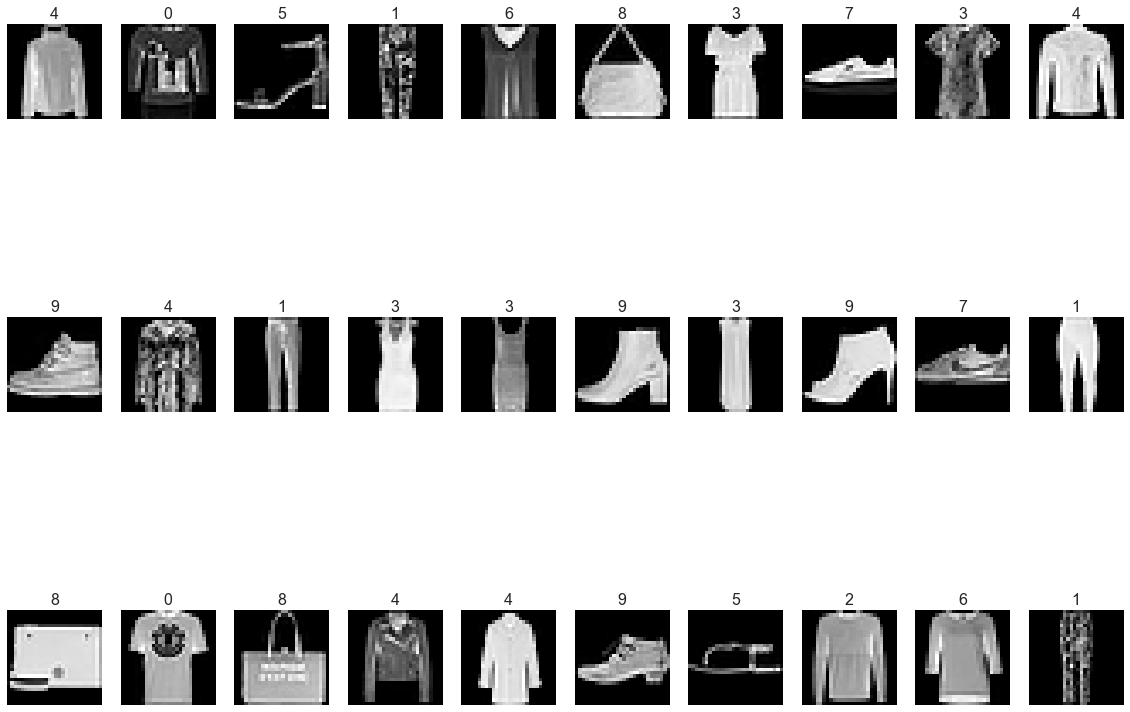

In [5]:
sampled, label = sample(30, X_train, y_train)
plot_images(sampled, label)

When it comes to clothing classifcation, the most important thing should be the location of the images on the xy plane. As such, in between pixel values would not contribute to the overall prediction.

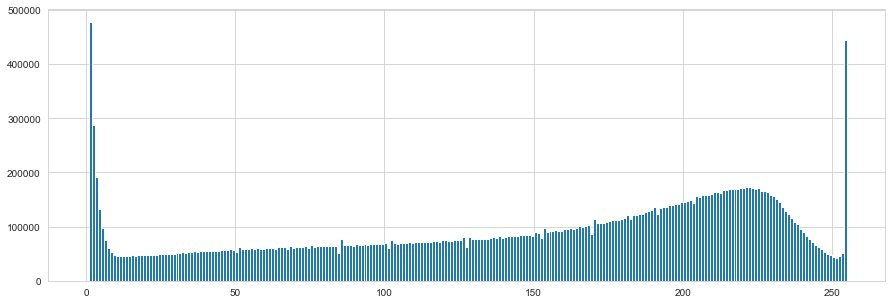

In [6]:
flattened = X_train.reshape(X_train.shape[0], -1)
pixel, counts = np.unique(flattened[flattened != 0], return_counts = True)

pixel_distribution = dict(zip(pixel, counts))
plt.figure(figsize = (15, 5))
plt.hist(pixel_distribution.keys(), weights = pixel_distribution.values(), bins = np.arange(0, 256))
plt.show()

## Preprocessing data using OpenCV

1) I will use Gaussian Blur to filter out noise in the images

In [7]:
def apply_blurring(X: np.array, plot: bool = False):
    index = np.random.randint(0, X.shape[0], size = 4)
    sampled = X[index]
    
    fig, ax = plt.subplots(4, 4, figsize = (10, 10))
    kernel_size = [1, 3, 5, 7]
    if plot:
        for x, image in enumerate(sampled):
            for y, kernel in enumerate(kernel_size):
                blur = cv2.GaussianBlur(image, (kernel, kernel), 0)
                ax[x][y].set(xticks = [], yticks = [], title = f"Kernel: {kernel}")
                ax[x][y].imshow(blur, cmap = "gray")

I will choose the kernel size to be 1 here. 

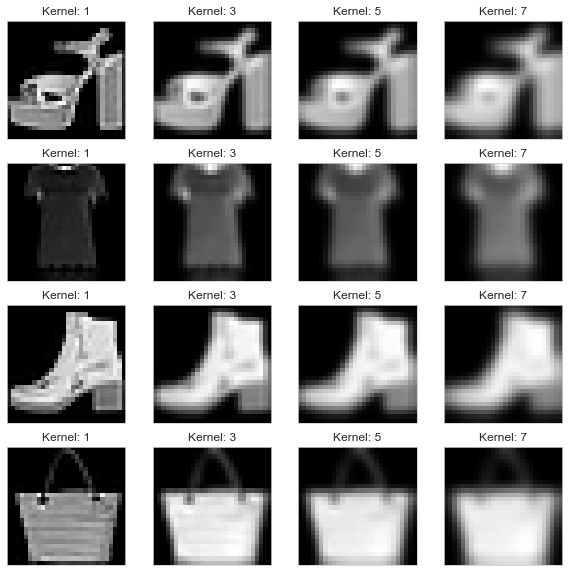

In [8]:
apply_blurring(X_train, plot = True)

2) Using thresholding, I can convert this images into black and white while keeping its shape using the parameters for Gaussian Blur found above

In [9]:
def get_threshold(X: np.array, plot: bool = False):
    index = np.random.randint(0, X.shape[0], size = 4)
    sampled = X[index]
    
    fig, ax = plt.subplots(4, 6, figsize = (10, 10))
    if plot:
        for x, image in enumerate(sampled):
            for i, boundary in enumerate(range(20, 80, 10)):
                blur = cv2.GaussianBlur(image, (1, 1), 0)
                _, threshold = cv2.threshold(blur, boundary, 255, cv2.THRESH_BINARY)
                ax[x][i].set(xticks = [], yticks = [], title = f"Boundary: {boundary}")
                ax[x][i].imshow(threshold, cmap = "gray")
            
    _, threshold = cv2.threshold(sampled, 50, 255, cv2.THRESH_BINARY)
    return threshold

I will choose the threshold to be 20.

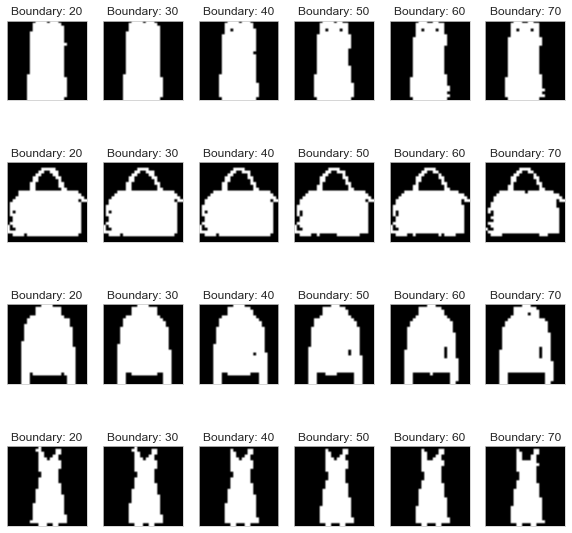

In [10]:
threshold = get_threshold(X_train, plot = True)

3) I will now apply dilation to fill in black spots in the picture.

In [11]:
def dilation(X: np.array, plot: bool = False):
    index = np.random.randint(0, X.shape[0], size = 4)
    sampled = X[index]
    
    fig, ax = plt.subplots(4, 3, figsize = (10, 10))
    kernel = []
    for i in range(1, 4):
        kernel.append(np.ones((i, i)))
    if plot:
        for x, image in enumerate(sampled):
            for i, kernel_size in enumerate(kernel):
                blur = cv2.GaussianBlur(image, (1, 1), 0)
                _, threshold = cv2.threshold(blur, 20, 255, cv2.THRESH_BINARY)
                dilated = cv2.dilate(threshold, kernel_size, iterations = 1)
                ax[x][i].set(xticks = [], yticks = [], title = f"Kernel: {kernel_size.shape}")
                ax[x][i].imshow(dilated, cmap = "gray")

I will choose the kernel size to be 2. 

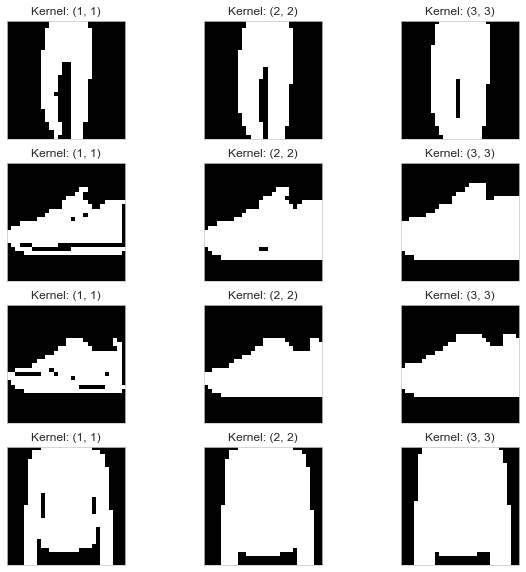

In [12]:
dilation(X_train, plot = True)

4) Finally, using the 3 steps found above, I will extract the edge of the clothings using Canny

In [42]:
def edge_detection(X: np.array, plot: bool = False):
    index = np.random.randint(0, X.shape[0], size = 5)
    sampled = X[index]
    
    fig, ax = plt.subplots(1, 5, figsize = (10, 10))
    kernel = []
    if plot:
        for i, image in enumerate(sampled):
            blur = cv2.GaussianBlur(image, (1, 1), 0)
            _, threshold = cv2.threshold(blur, 10, 255, cv2.THRESH_BINARY)
            dilated = cv2.dilate(threshold, (2, 2), iterations = 1)
            edge = cv2.Canny(dilated, 0, 255)
            ax[i].set(xticks = [], yticks = [])
            ax[i].imshow(edge, cmap = "gray")

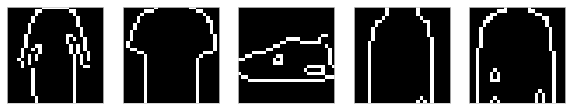

In [45]:
edge_detection(X_train, plot = True)

Using this preprocessing methods, we can now prepare our dataset